In [36]:
import numpy as np
import pandas as pd
import glob
from model.ctabgan import CTABGAN
df = pd.read_csv("Real_Datasets/adult.csv")
#df = df.drop(columns=['Year','Model'])
df = df[['age', 'workclass', 'capital-gain',"fnlwgt"]]
df = df.head(1000)
#df.loc[:7, 'capital-gain'] = np.nan
df.head(20)

,age,workclass,capital-gain,fnlwgt
0,25,4,0,226802
1,38,4,0,89814
2,28,2,0,336951
3,44,4,7688,160323
4,18,0,0,103497
5,34,4,0,198693
6,29,0,0,227026
7,63,6,3103,104626
8,24,4,0,369667
9,55,4,0,104996


In [ ]:
synthesizer =  CTABGAN(df,
                 categorical_columns = ["workclass"], 
                 log_columns = {}, # Fuck this log, task for tommorrow
                 mixed_columns= {"capital-gain": [0]},
                 gaussian_columns = [],
                 non_categorical_columns = [],
                 integer_columns = []) 

In [38]:
synthesizer.fit(100)

100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


In [39]:
syn = synthesizer.generate_samples(1000)
syn.head(50)

,age,workclass,capital-gain,fnlwgt
0,30,4,5312,81600
1,22,4,0,81601
2,38,4,0,81600
3,33,4,0,81825
4,42,0,0,362917
5,47,2,0,180809
6,57,6,0,374856
7,36,4,0,81600
8,56,2,0,180809
9,22,4,0,81601


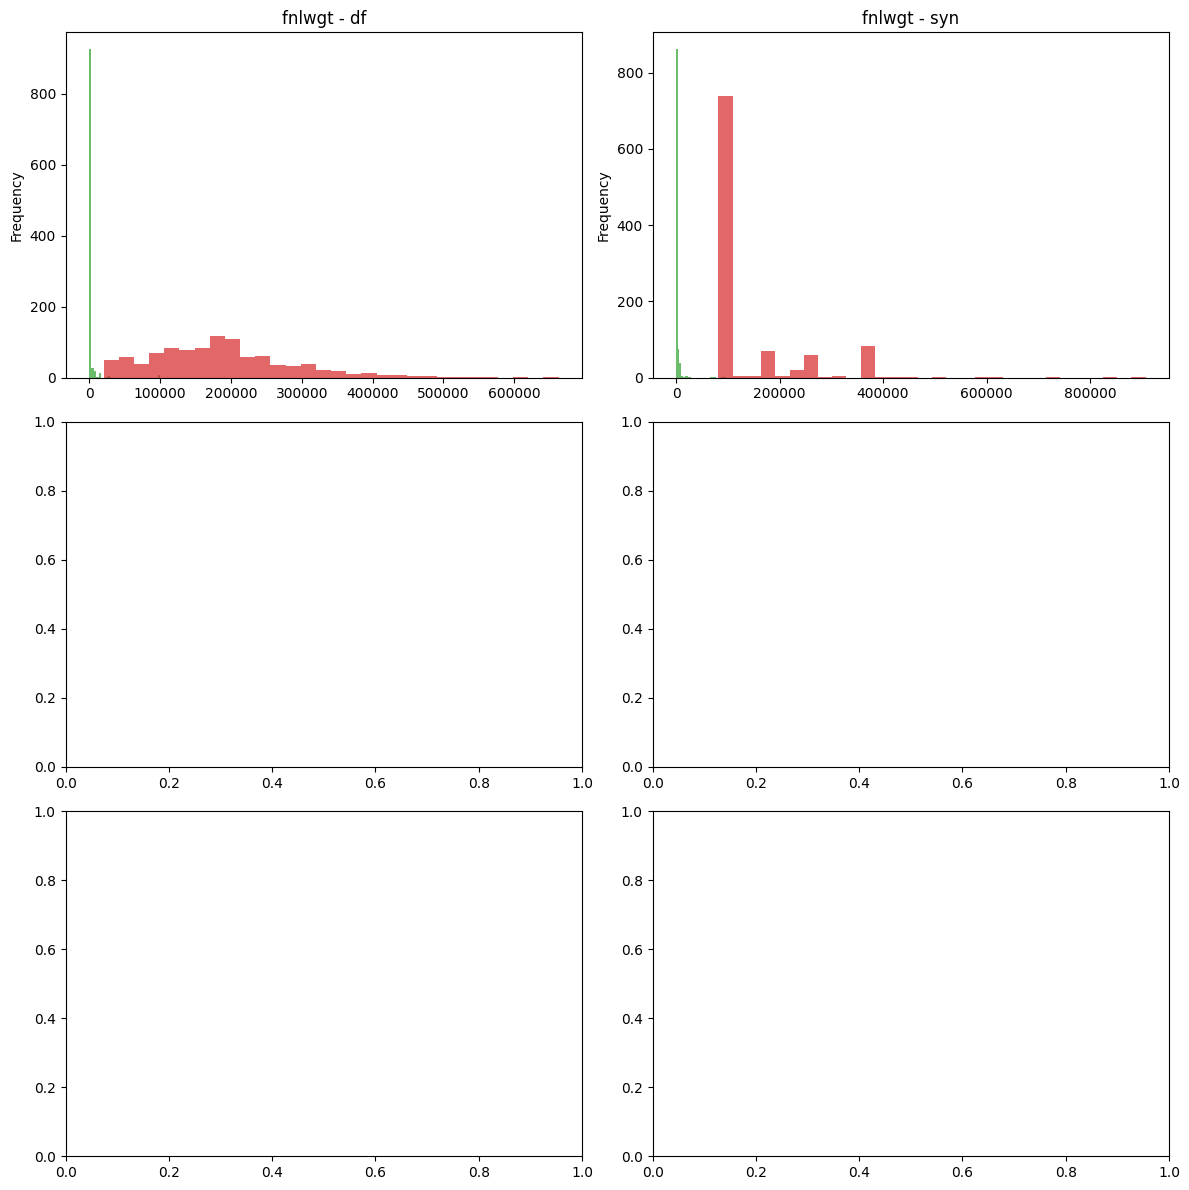

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

columns = df.columns

for i, column in enumerate(columns):
    df[column].plot(kind='hist', ax=axes[i, 0], title=f'{column} - df', bins=30, alpha=0.7)
    syn[column].plot(kind='hist', ax=axes[i, 1], title=f'{column} - syn', bins=30, alpha=0.7)

plt.tight_layout()
plt.show()


In [30]:

from model.eval.evaluation import stat_sim

stat_sim(df,syn, ["workclass"])


column:  age WD:  0.03595890410958903
column:  workclass JSD:  0.1393446282646894
column:  capital-gain WD:  0.05992208922089218


[np.float64(0.047940496665240605),
 np.float64(0.1393446282646894),
 np.float64(0.22150192894620577)]

In [34]:
from model.eval.evaluation import privacy_metrics
privacy_metrics(df,syn)

array([[0.12362016, 0.        , 0.        , 0.56799364,        nan,
               nan]])